 # todos



 ## general todos

[ ] eventually fix the paths for anyone not running this from src directory (remove ...)

[x] map setup numbers to better names for all plots

[ ] traverse setup folders and concat dfs

[ ] do some significance tests based on results_df

[ ] combine ALL the run results and do a regression with a lot more parameters!

 ## Plots I want this to work on

[ ] Time plot?

[x] Fitness_plot

    [ ] comparing best vs. avg vs best species (needs to be only done once)

[x] Total components?

[x] Unique components per generation

[x] Mutation boxplot effects

[x] fitness Metrics plots



[ ] best genome mutation analysis

[x] Mutation lineplots

[x] Average metrics?

[ ] Number species

[x] Spawn rank histogram

[x] Scatterplot

 ## Do not forget about single-run plots, they should also be in here

[ ] best genome lineage

[ ] species leaders??

[ ] species stackplot

[ ] species tree

[ ] species ridgeline

[ ] species average fitnesses

[ ] fitness scatterplot (as implemented in look_at_dfs) - can only do that for one run

 ## Other analysis implemented someplace else

[ ] ... check the onenote

 ## Interesting one-off analysis

[ ] Mutation lineage for a selected run

[ ] Component similarity drift

[ ] Fitness of components plotting

    - Look at the components in the fittest genome at the end, plot their t-values obtained from the component dict over the generations

 ## Those can only be copied from a run

[ ] improvements (combine them into something)

[ ] species leaders??

# Analysis of results
In this notebook, I will track all the plots used in the Thesis.

The first step will be evaluating individual selection strategies, with the goal of determining appropriate parameter settings for each selection strategy before comparing the selection strategies agains one another.

For those initial comparisons, I will be sticking to the `running_example.xes` log, but bigger logs will be compared.

## Selection strategy - truncation
First off, analyzing the truncation selection strategy

The Data is from a run with the following parameter permutations
* `spawn_cutoff`: 0.1, 0.25, 0.5, 0.75
* `pop_perc_elite`: 0.05, 0.1
* `pop_perc_crossover`: 0.1, 0.2, 0.3, 0.4

## Truncation - effect of spawn cutoff
Probably the most influental parameter, it should directly expose the trade-offs of diversity vs. focus during the search. I.e. trading faster convergence for a narrower search. `spawn_cutoff` determines which portion of the population will be moved into the next.

For every parameter change, all the other parameter changes are also tested, resulting in a total of `4*2*4 = 32` setups. That also means that The spawn cutoff was tested with all `pop_perc_elite` and `pop_perc_crossover` settings. Each setup was run 20 times.

To investigate the hypothesis that spawn cutoff has the largest effect on achieved diversity, I rely on the num_components metric which was calculated for every run, as well as the highest achieved fitness and do a regression for both of those target variables. Predictors are the params that were changed, i.e. spawn cutoff, % elite spawns and % crossover spawns.

In [2]:
from importlib import reload # TODO: remove this later
import scripts.helper_scripts.setup_analysis as sa # helper module for fetching setup analysis
# crawl the results data and load it into a dict
res = sa.exec_results_crawler("../analysis/data/testing_truncation")

Processing setup directories: 10it [00:00, 97.88it/s]


Found cached results for setup_1
Successfully loaded cached results for setup_1

Found cached results for setup_10
Successfully loaded cached results for setup_10

Found cached results for setup_11
Successfully loaded cached results for setup_11

Found cached results for setup_12
Successfully loaded cached results for setup_12

Found cached results for setup_13
Successfully loaded cached results for setup_13

Found cached results for setup_14
Successfully loaded cached results for setup_14

Found cached results for setup_15
Successfully loaded cached results for setup_15

Found cached results for setup_16
Successfully loaded cached results for setup_16

Found cached results for setup_17
Successfully loaded cached results for setup_17

Found cached results for setup_18
Successfully loaded cached results for setup_18

Found cached results for setup_19
Successfully loaded cached results for setup_19

Found cached results for setup_2
Successfully loaded cached results for setup_2

Found c

Processing setup directories: 29it [00:00, 87.03it/s]

Successfully loaded cached results for setup_24

Found cached results for setup_25
Successfully loaded cached results for setup_25

Found cached results for setup_26
Successfully loaded cached results for setup_26

Found cached results for setup_27
Successfully loaded cached results for setup_27

Found cached results for setup_28
Successfully loaded cached results for setup_28

Found cached results for setup_29
Successfully loaded cached results for setup_29

Found cached results for setup_3
Successfully loaded cached results for setup_3

Found cached results for setup_30
Successfully loaded cached results for setup_30

Found cached results for setup_31
Successfully loaded cached results for setup_31

Found cached results for setup_32
Successfully loaded cached results for setup_32

Found cached results for setup_4
Successfully loaded cached results for setup_4

Found cached results for setup_5
Successfully loaded cached results for setup_5

Found cached results for setup_6
Successfull

Processing setup directories: 35it [00:00, 85.88it/s]


In [3]:
regression_result = sa.run_regression(res, ["spawn_cutoff", "pop_perc_elite", "pop_perc_crossover"]);


Regression Results for num_components
--------------------------------------------------
R-squared: 0.9327
Adjusted R-squared: 0.9324

Standardized Coefficients:
spawn_cutoff          1234.5024 (p=0.0000)
pop_perc_elite        -249.5047 (p=0.0000)
pop_perc_crossover      50.8167 (p=0.0002)

Regression Results for max_fitness
--------------------------------------------------
R-squared: 0.0051
Adjusted R-squared: 0.0004

Standardized Coefficients:
spawn_cutoff             0.0046 (p=0.1380)
pop_perc_elite          -0.0032 (p=0.3029)
pop_perc_crossover       0.0004 (p=0.8948)


Turns out that 93% of the variance in num_components can be explained by the selected parameters. All three predictors have significant effects on the number of components, with the largest effect being the positive effect of increasing the cutoff. Increasing the number of elite spawns, which are simply cloning the best genome without mutations (with the goal to increase the fraction of elite genomes in the spawnpool so they will mutate in the next generation) leads as expected to a decrease in diversity. And while the tested parameter differences for the crossover percentage are much larger than those for elite spawns (0.1-0.4 vs. just 0.05 to 0.1), crossover has the smallest effect on diversity in truncation selection. 

**TODO**: why might this be? hypothesis for crossover effect so small on diversity?

On the other hand, the effects of the tested parameters are pretty minimal on the achieved maximum fitness, with none being significant. This is because for this small log there is almost no correlation between diversity and max fitness achieved - as will be seen later in **TODO**: DO A SCATTER OF ALL THE RUNS AND CALC COMPONENT ~ FITNESS CORR. + test log size increases maybe change in the relation of diversity x fitness

When it comes to the highest achievable fitness, there are bigger knobs to turn - other selection strategies, mutation rates and the fitness function itself.

The barcharts below show the setups using the different cutoff and crossover settings. Each of the shown bars is an average of all the runs where the cutoff and crossover settings are matching, which also includes for every bar the two tested elitism settings (as elitism does not make a huge difference, they were aggregated together for those visualizations & to save the complexity of showing all 32 permuations of settings).

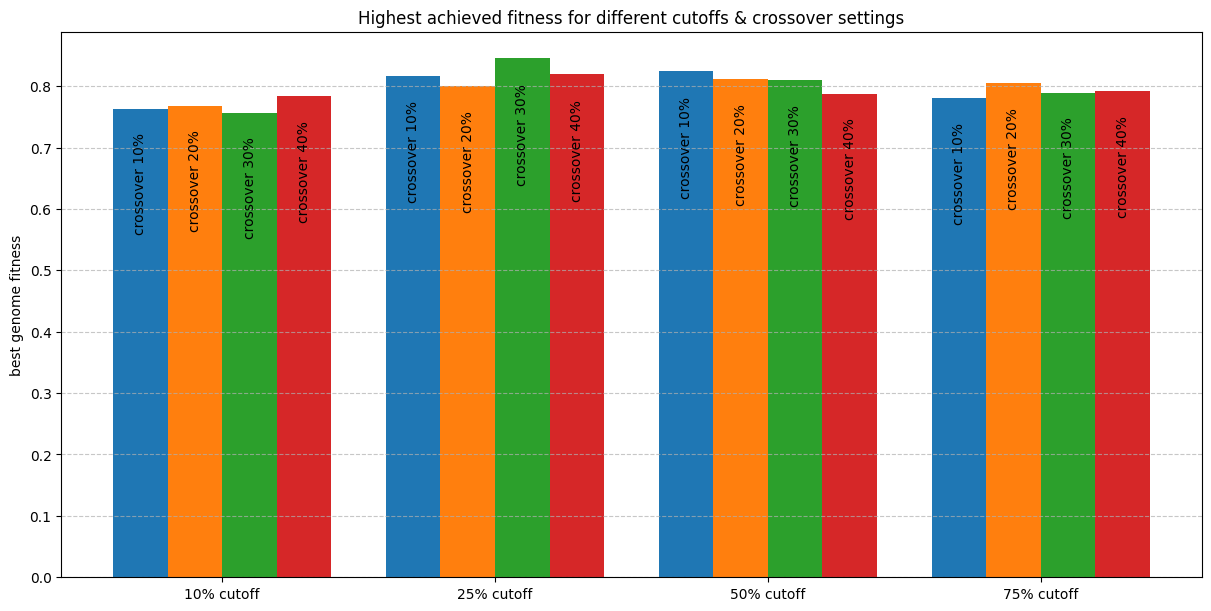

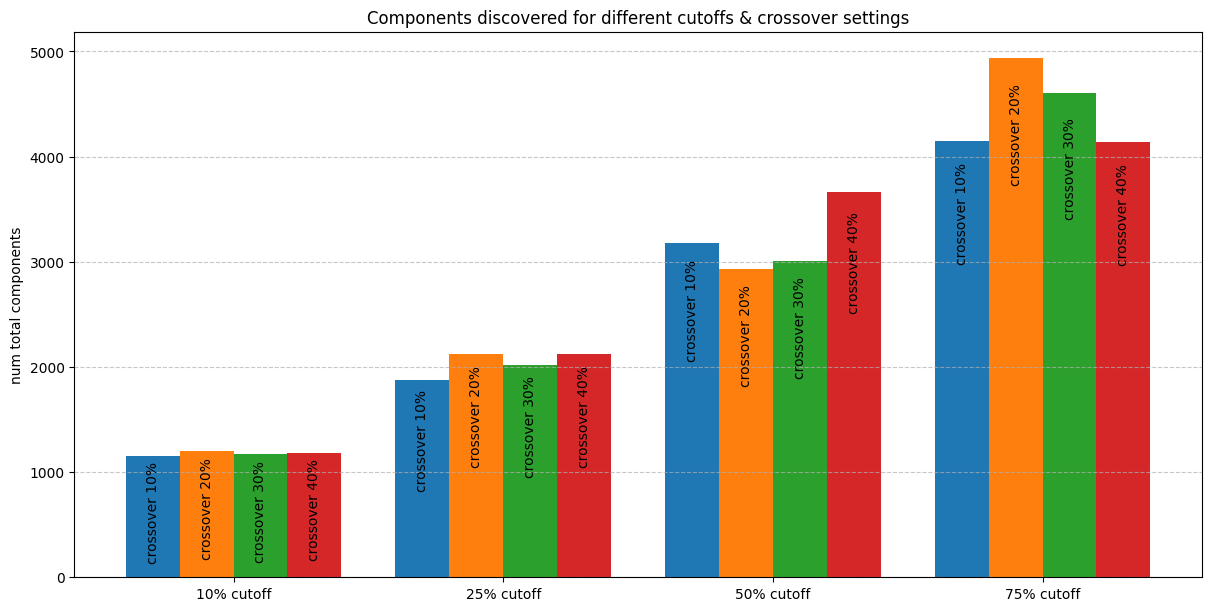

In [26]:
reload(sa)

search = {
    "cutoff 10% & crossover 10%": {"spawn_cutoff": 0.1, "pop_perc_crossover": 0.1}, "cutoff 10% & crossover 20%": {"spawn_cutoff": 0.1, "pop_perc_crossover": 0.2}, "cutoff 10% & crossover 30%": {"spawn_cutoff": 0.1, "pop_perc_crossover": 0.3}, "cutoff 10% & crossover 40%": {"spawn_cutoff": 0.1, "pop_perc_crossover": 0.4},
    "cutoff 25% & crossover 10%": {"spawn_cutoff": 0.25, "pop_perc_crossover": 0.1}, "cutoff 25% & crossover 20%": {"spawn_cutoff": 0.25, "pop_perc_crossover": 0.2}, "cutoff 25% & crossover 30%": {"spawn_cutoff": 0.25, "pop_perc_crossover": 0.3}, "cutoff 25% & crossover 40%": {"spawn_cutoff": 0.25, "pop_perc_crossover": 0.4},
    "cutoff 50% & crossover 10%": {"spawn_cutoff": 0.50, "pop_perc_crossover": 0.1}, "cutoff 50% & crossover 20%": {"spawn_cutoff": 0.50, "pop_perc_crossover": 0.2}, "cutoff 50% & crossover 30%": {"spawn_cutoff": 0.50, "pop_perc_crossover": 0.3}, "cutoff 50% & crossover 40%": {"spawn_cutoff": 0.50, "pop_perc_crossover": 0.4},
    "cutoff 75% & crossover 10%": {"spawn_cutoff": 0.75, "pop_perc_crossover": 0.1}, "cutoff 75% & crossover 20%": {"spawn_cutoff": 0.75, "pop_perc_crossover": 0.2}, "cutoff 75% & crossover 30%": {"spawn_cutoff": 0.75, "pop_perc_crossover": 0.3}, "cutoff 75% & crossover 40%": {"spawn_cutoff": 0.75, "pop_perc_crossover": 0.4},
}

plt_layout = [
    ["cutoff 10% & crossover 10%", "cutoff 10% & crossover 20%", "cutoff 10% & crossover 30%", "cutoff 10% & crossover 40%"],
    ["cutoff 25% & crossover 10%", "cutoff 25% & crossover 20%", "cutoff 25% & crossover 30%", "cutoff 25% & crossover 40%"],
    ["cutoff 50% & crossover 10%", "cutoff 50% & crossover 20%", "cutoff 50% & crossover 30%", "cutoff 50% & crossover 40%"],
    ["cutoff 75% & crossover 10%", "cutoff 75% & crossover 20%", "cutoff 75% & crossover 30%", "cutoff 75% & crossover 40%"]
]


data_sources = sa.search_and_aggregate_param_results(res, search)
strip_first_param = lambda l: l.split('&')[1].strip().split('\n')[0] # lambda to be applied on labels
_ = sa.generalized_barplot(plt_layout, data_sources, "best_genome_fitness", title="Highest achieved fitness for different cutoffs & crossover settings", group_titles=["10% cutoff", "25% cutoff", "50% cutoff", "75% cutoff"], label_lambda=strip_first_param)
_ = sa.generalized_barplot(plt_layout, data_sources, "num_total_components", title="Components discovered for different cutoffs & crossover settings", group_titles=["10% cutoff", "25% cutoff", "50% cutoff", "75% cutoff"], label_lambda=strip_first_param)

This again shows how none of the settings really have an impact on the achieved mean fitness. At the end, I will compare all setups, i.e. all parameter permutations to identify the best settings within my sample and compare that to the analysis here.

In the next step, I want to analyze how truncation selection convergences towards it's optimum in the different parameter settings. From now on, I will include only the setups with 0.05% elite spawns, as this will be the setting that seems more optimal going forward, as based on the regression results - increasing the number of elite spawns seems to have a detrimental effect on the fitness.

First, I will analyze how quickly the maximum fitness is achieved. Similarly, I will plot the number of components discovered in each generation on average to see how quickly the search widens.  Lastly, I will compare that with how quickly each setup converges to a smaller set of unique components, as selection pressure discards most components that are not useful.

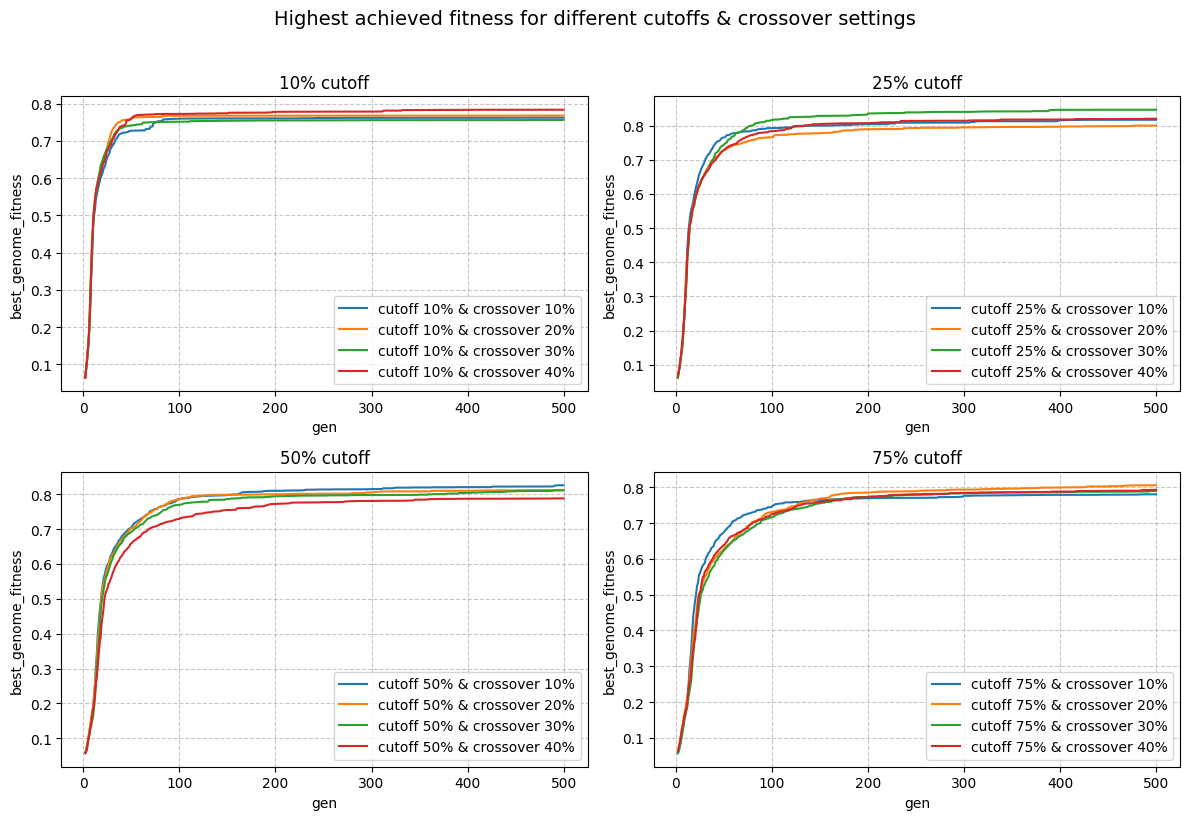

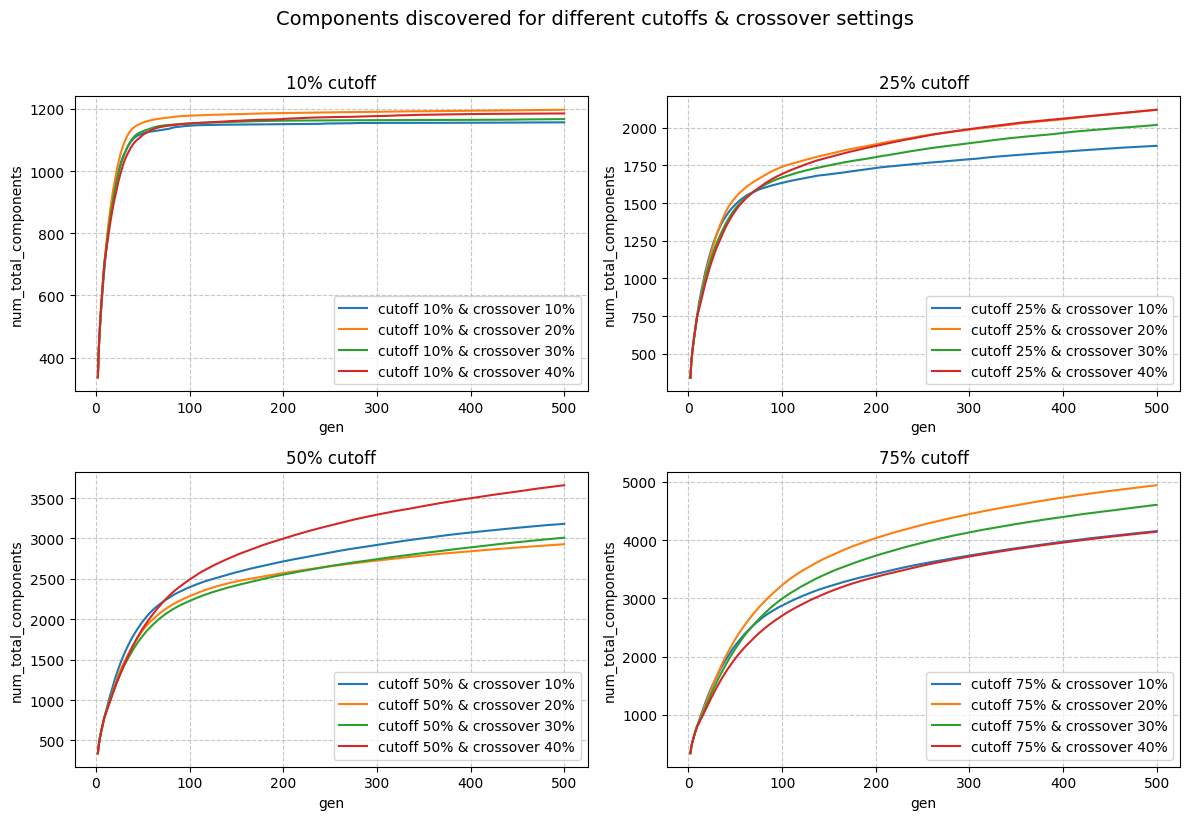

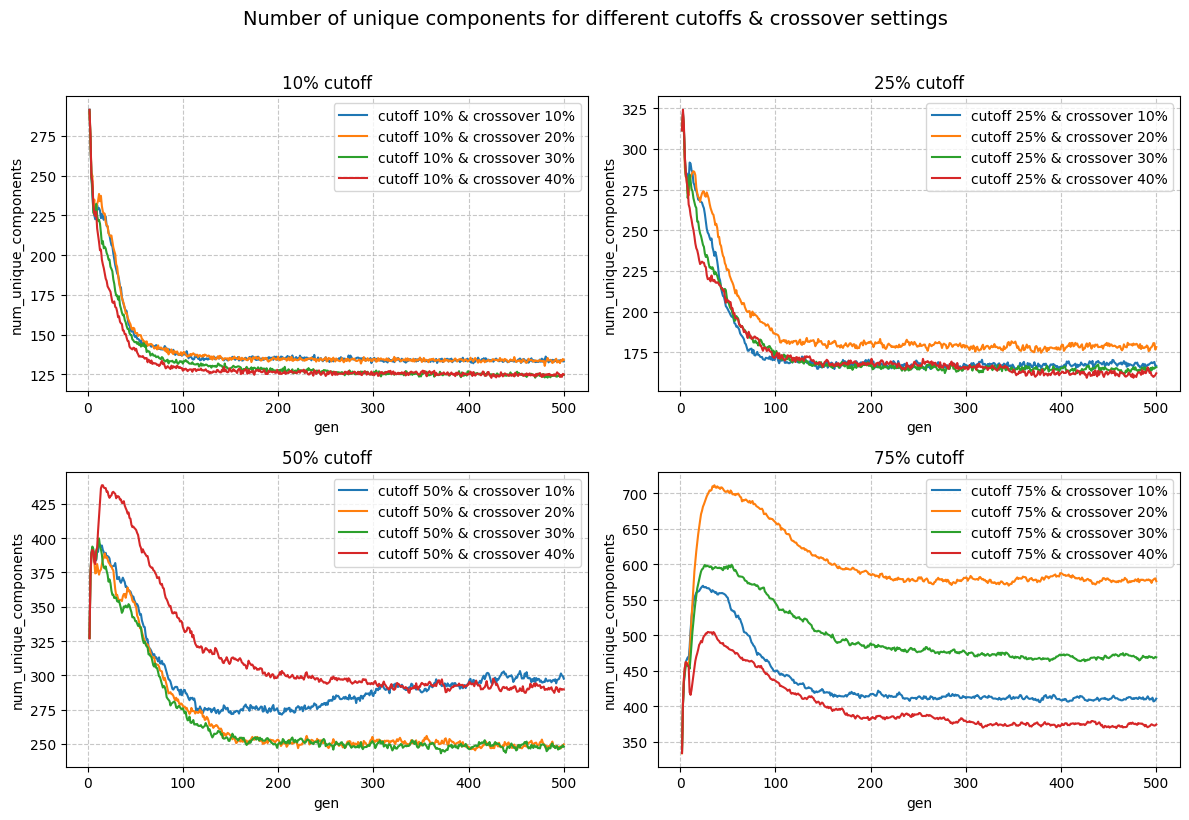

In [31]:
from copy import deepcopy
reload(sa)

# updating search to filter only for 0.05% elite spawns
filtered_search = deepcopy(search)
for p_dict in filtered_search.values():
    p_dict["pop_perc_elite"] = 0.05

filtered_data_sources = sa.search_and_aggregate_param_results(res, filtered_search)
_ = sa.generalized_lineplot(plt_layout, data_sources, "best_genome_fitness", title="Highest achieved fitness for different cutoffs & crossover settings", subplt_titles=["10% cutoff", "25% cutoff", "50% cutoff", "75% cutoff"])
_ = sa.generalized_lineplot(plt_layout, data_sources, "num_total_components", title="Components discovered for different cutoffs & crossover settings", subplt_titles=["10% cutoff", "25% cutoff", "50% cutoff", "75% cutoff"])
_ = sa.generalized_lineplot(plt_layout, data_sources, "num_unique_components", title="Number of unique components for different cutoffs & crossover settings", subplt_titles=["10% cutoff", "25% cutoff", "50% cutoff", "75% cutoff"], legend_loc="upper right")

**Observations:**
* highest fitness:
* num components:
* unique components:
    * Independent of the chosen cutoff setting, all graphs show that there are roughly ~275 to ~325 components in the first generation. All graphs generally decrease in the number of unique components once an optimum is approached. The difference is how long it takes until this decline starts
        * With a low spawn cutoff (10% & 25%), the diversity starts to decrease pretty much at the start.
        * With a higher cutoff (50% & 75%), the diversity continues to rise for longer. and there are more unique components both at the peak and also towards the end of the run.
    * For all the tested parameters, crossover starts after 10 generations, and has the initial effect of decreasing the diversity, after which it quickly rebounds. This spike can be seen best on the 40% crossover line at 75% truncation (4th. Quadrant, red line).
    * Effect of different crossover rates is limited when a low cutoff is used. Probably because the search is already really focused and trends towards a very small number of components such that the crossover settings don't make much of a difference.
    * Curiously both the highest and lowest crossover rates trend similarly in the higher cutoffs.
        * However, the relation between unique components and crossover rate seems to flip when changing from 50% cutoff to 75% cutoff. In 50% cutoff runs, a high crossover rate of 40% preserves more components until the end, but the 10% crossover catches up to it.
        * In the 75% cutoff both 10% and 40% crossover trend similarly towards a lower number of unique components, with the 20% crossover rate conserving the highest numer of different components.

Curious effect of crossover on unique components **TODO**

**TODO:** unique components elbow rule convergence with peak fitness at gen 100
**TODO:** Mention long tail of optimizations, even though fitness seems to plateau on these graphs after ~100 gens

In [ ]:
sa.generalized_lineplot(plt_layout, data_sources, "num_total_components")
sa.generalized_lineplot(plt_layout, data_sources, "best_genome_fitness")
sa.generalized_lineplot(plt_layout, data_sources, "avg_pop_fitness")
sa.generalized_lineplot(plt_layout, data_sources, "num_unique_components")

sa.generalized_barplot(plt_layout, data_sources, "num_total_components")





In [ ]:
# %%
res["setups"][1]['gen_info_agg']



In [ ]:
# %%
# for truncation
res = sa.exec_results_crawler("../analysis/data/testing_truncation")

search = {
    "spawn_cutoff_10%": {"spawn_cutoff": 0.1},
    "spawn_cutoff_25%": {"spawn_cutoff": 0.25},
    "spawn_cutoff_50%": {"spawn_cutoff": 0.50},
    "spawn_cutoff_75%": {"spawn_cutoff": 0.75},
}

plt_layout = [["spawn_cutoff_10%", "spawn_cutoff_25%", "spawn_cutoff_50%", "spawn_cutoff_75%"]]

data_sources = sa.search_and_aggregate_param_results(res, search)

sa.generalized_lineplot(plt_layout, data_sources, "num_total_components")
sa.generalized_lineplot(plt_layout, data_sources, "best_genome_fitness")
sa.generalized_lineplot(plt_layout, data_sources, "avg_pop_fitness")
sa.generalized_lineplot(plt_layout, data_sources, "num_unique_components")
sa.generalized_barplot(plt_layout, data_sources, "num_total_components")